# Figures etc.

Note that calling `plt.show` with high DPI makes the figures really big in Jupyterlab. This is annoying so use `plt.savefig` to get high-DPI versions of each figure.

This notebook creates each figure in a standalone function.

In [1]:
!pip -q install scienceplots matplotlib-map-utils contextily

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import scienceplots

# science base style + sans serif fonts + grid by default
plt.style.use(["science", "notebook", "grid"])

matplotlib.rcParams["savefig.dpi"] = 300

POSTER_RC = {
    "font.size":24, 
    "axes.linewidth": 2.0, 
    "grid.linewidth": 2.0
}

PAPER_RC = {
    "font.size": 12
}

OUTPUT_FIGURE_DIRECTORY = "../figures"

### Soap Mort and West Mort extents

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


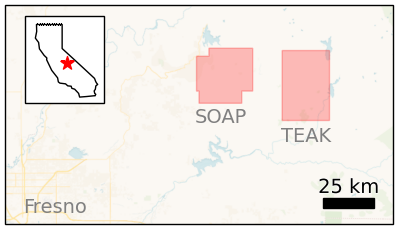

In [3]:
import yaml
import shapely
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import contextily as cx
import matplotlib_map_utils as mpl_map
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def fig1_soap_teak_extents():
    # Get the natural earth polygon for California
    fn = shpreader.natural_earth(
        resolution='110m', category='cultural', 
        name='admin_1_states_provinces',
    )
    reader = shpreader.Reader(fn)
    cali = next(filter(lambda x: x.attributes["name"] == "California", reader.records()))
    cali = gpd.GeoSeries([cali.geometry], crs=4326)
    
    # Appproximate boundaries of SOAP and TEAK
    aop_boxes = gpd.read_file("../data_in/aop_boundaries/AOP_flightboxesAllSites.shp").to_crs(3857)
    soap_teak = aop_boxes[aop_boxes.siteID.isin(["SOAP", "TEAK"])]
    soap_teak["geometry"] = soap_teak["geometry"].buffer(100)
    soap_teak = soap_teak.dissolve(by="siteID")
    centroid = soap_teak.dissolve().centroid
    
    # Map extents
    extent_ca = -126.024414, -113.021484, 31.575612, 42.998222
    extent_fresno = -119.837744, -118.802283, 36.729433, 37.197821
    fresno = -13334904.5252,4404893.9568
    soap = -13276206.261691,4431759.156165
    teak = -13250689.547734,4425919.445224
    projection = ccrs.Mercator.GOOGLE # 3857
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 5), subplot_kw={'projection': projection})
    inset_ax = inset_axes(
        ax, width="100%", height="100%", loc='upper left',
        bbox_transform=ax.transAxes,
        axes_class=cartopy.mpl.geoaxes.GeoAxes,
        axes_kwargs=dict(projection=projection),
        bbox_to_anchor=(0, 0.6, 0.25, 0.40)
    )
    
    
    # Inset axes with California only
    cali.to_crs(projection.proj4_init).plot(ax=inset_ax, edgecolor='black', linewidth=1.0, facecolor="white")
    centroid.to_crs(projection.proj4_init).plot(ax=inset_ax, color="red", marker="*", markersize=100)
    inset_ax.set_extent(extent_ca)
    
    # Main axes with AOP boundaries
    soap_teak.plot(ax=ax, alpha=0.25, facecolor="red", edgecolor="red")
    ax.set_extent(extent_fresno)
    cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)
    mpl_map.scale_bar(
        ax, location="lower right", 
        bar={
            "projection": projection,
            "unit": "km",
            "max": 25,
            "major_div": 1
        },
        text={"fontsize": 14},
        labels={"sep": 0, "loc": "above", "style": "last_only"},
        units={"loc": "text"}
    )
    ax.plot(*fresno, markersize=100, transform=projection._as_mpl_transform(ax))
    ax.annotate('Fresno', xy=fresno, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax))
    ax.annotate('SOAP', xy=soap, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax), horizontalalignment="center")
    ax.annotate('TEAK', xy=teak, color="0.5", fontsize=14, xycoords=projection._as_mpl_transform(ax), horizontalalignment="center")
    
    fig.set_size_inches(5, 3)

    return fig, ax, inset_ax

fig1_soap_teak_extents()
plt.show()

In [4]:
import xarray as xr
from matplotlib.patches import Patch

def forest_binary_raster(coarsen_factor=4):
    forest = xr.open_dataset("../mort_datasets/westmort.nc")["treecover"]
    forest = forest > 10 # FAO definition
    # Coarsen this to 4km to reduce speckle
    forest_coarse = forest.rolling(x=coarsen_factor, y=coarsen_factor).max()
    forest_coarse = forest_coarse.where(forest_coarse > 0)
    return forest_coarse

forest = forest_binary_raster(coarsen_factor=4)

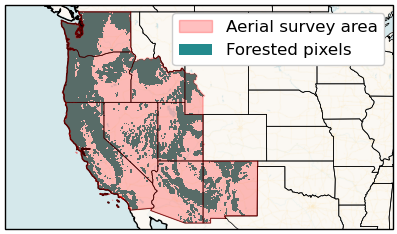

In [5]:
def fig1_west_mort_extent():
    usfs_regions = gpd.read_file("../data_in/usfs_region_boundaries/S_USA.AdministrativeRegion.shp")
    usfs_regions = usfs_regions[usfs_regions.REGION.isin(["03", "04", "05", "06"])]
    usfs_dissolve = gpd.GeoSeries(usfs_regions.geometry.to_crs(3857).buffer(0.02).union_all(), crs=3857).simplify(1000)
    
    # Drop Hawaii
    generous_bbox = -14575970.6533,3602511.7427,-9808183.4092,6359699.3948
    usfs_dissolve = usfs_dissolve.clip_by_rect(*generous_bbox)
    
    # Clip forest cover to the survey boundary
    forest_clip = forest.rio.write_crs(3857).rio.clip(usfs_dissolve)
    
    projection = ccrs.Mercator.GOOGLE
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={"projection": projection})
    
    forest_clip.plot(
        ax=ax,
        transform=projection,
        add_colorbar=False
    )
    ax.set_title("")
    
    map_bbox = (generous_bbox[0], generous_bbox[2], generous_bbox[1], generous_bbox[3]) # >:(
    
    ax.coastlines(linewidth=1.0)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    usfs_dissolve.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.25, zorder=5)
    #usfs_dissolve.plot(ax=ax, facecolor="none", edgecolor="red", alpha=1, zorder=5)
    ax.set_extent(map_bbox, crs=projection)
    cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)
    
    patches = [
        Patch(facecolor="red", edgecolor="red", alpha=0.25, label="Aerial survey area"),
        Patch(facecolor="#238a8d", alpha=1, label="Forested pixels")
    ]
    ax.legend(handles=patches, loc="upper right", prop=dict(size=12))

    return fig, ax

fig, ax = fig1_west_mort_extent()
plt.show()

### Intersection over union vs. AC(1) heatmap

This one is kinda slow soz

In [6]:
import numpy as np
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def lag1_autocorr(arr):
    ac = acf(arr, nlags=1, missing="conservative")
    return ac[1]

def survey_mask(min_valid=0.5):
    ds = xr.open_dataset("../mort_datasets/westmort.nc")
    mort = ds.mortality.where(ds.treecover > 10)
    return (~np.isnan(mort)).astype(np.float16).mean(dim="time") > 0.5

def mort_autocor():
    ds  = xr.open_dataset("../mort_datasets/westmort.nc")
    mort = ds.mortality.where(ds.treecover > 10)
    
    return xr.apply_ufunc(
        lag1_autocorr,
        mort,
        input_core_dims=[["time"]],
        exclude_dims=set(["time"]),
        output_core_dims=[[]],
        vectorize=True
    )

def iou_mean():
    return xr.open_dataset("../mort_datasets/westmort_iou.nc").mean(dim="time")/100

mask = survey_mask()
ac = mort_autocor()
iou = iou_mean()

/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in scalar divide
  xo = x - x.sum() / notmask_int.sum()
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:518: RuntimeWarning: invalid value encountered in divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


AC(1) vs. mean IoU correlation: 0.5053798698384293


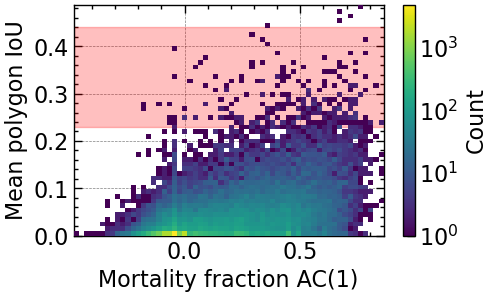

In [7]:
def fig3_autocor_heat_map():
    ac_mask = ac.where(survey_mask)
    iou_mask = iou.where(survey_mask)

    # Mask out the nans introduced by the survey mask
    ac_flat  = ac_mask.data.flatten()
    iou_flat = iou_mask.iou.data.flatten()
    mask = ~(np.isnan(ac_flat) | np.isnan(iou_flat))
    ac_nonan  = ac_flat[mask]
    iou_nonan = iou_flat[mask]
    
    fig = plt.figure(figsize=(5, 3))
    
    plt.hist2d(
        ac_nonan,
        iou_nonan,
        bins=(60, 50),
        norm=LogNorm(),
        zorder=3
    )
    
    plt.xlabel("Mortality fraction AC(1)")
    plt.ylabel("Mean polygon IoU")
    plt.colorbar(label="Count")
    plt.gca().axhspan(0.23, 0.44, alpha=0.25, color="red")

    print("AC(1) vs. mean IoU correlation:", np.corrcoef(ac_nonan, iou_nonan)[0, 1])

    return fig, plt.gca()

fig, ax = fig3_autocor_heat_map()
plt.show()

### Westmort model performance comparison

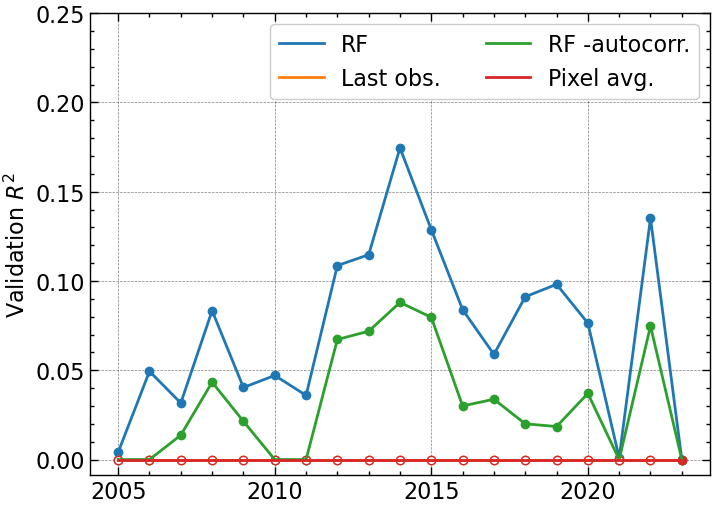

In [32]:
import pandas as pd
from matplotlib.colors import TABLEAU_COLORS

westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
westmort.head()


tableau_list = list(TABLEAU_COLORS.values())

westmort_ads = westmort[(westmort.data == "ADS")]
westmort_gfw = westmort[(westmort.data == "GFW")]

def model_performance_timeseries(df):
    model_remap = {
        "full RF": "RF",
        "lastobs": "Last obs.",
        "noac RF": "RF -autocorr.",
        "spatavg": "Pixel avg."
    }
    
    fig, ax = plt.subplots()
    
    for i, (model, data) in enumerate(df.groupby("model")):
        # Snap points < 0 to 0 for display, modify marker style to make it clear
        ev_lt0 = data["r2"] < 0
        ev_plt = np.maximum(0, data["r2"])
    
        # Start with basic line
        line = ax.plot(data["year"], ev_plt, label=model_remap[model], color=tableau_list[i])
    
        # Filled circles for years > 0
        p = ax.scatter(data["year"][~ev_lt0], ev_plt[~ev_lt0], c=tableau_list[i])
    
        # Open circles for years < 0
        ax.scatter(data["year"][ ev_lt0], ev_plt[ ev_lt0], facecolor="white", edgecolor=tableau_list[i])
    
    ax.set_xticks(range(2005, 2021, 5))
    
    plt.legend(ncol=2)
    plt.ylabel("Validation $R^2$")

    return fig, ax

def figs2_gfw_performance_timeseries():
    westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
    westmort_gfw = westmort[(westmort.data == "GFW")]
    fig, ax = model_performance_timeseries(westmort_gfw)
    ax.set_ylim(None, 0.25)
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    return fig, ax

fig, ax = figs2_gfw_performance_timeseries()
plt.show()

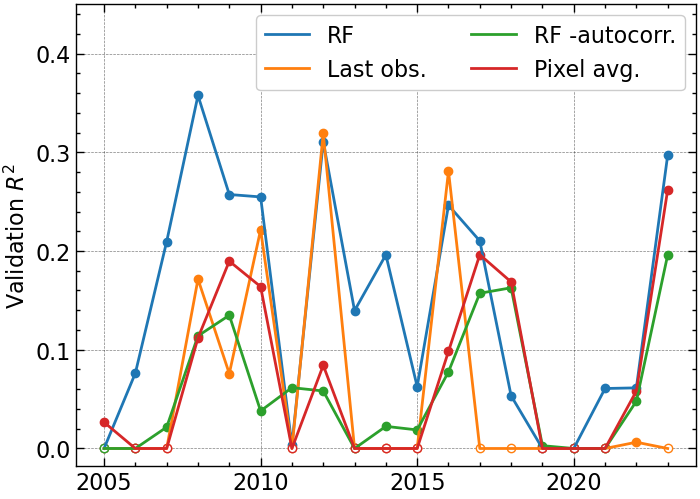

In [33]:
def figs3_ads_performance_timeseries():
    westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
    westmort_ads = westmort[(westmort.data == "ADS")]
    fig, ax = model_performance_timeseries(westmort_ads)
    ax.set_ylim(None, 0.45)
    return fig, ax

fig, ax = figs3_ads_performance_timeseries()
plt.show()

In [10]:
westmort = pd.read_csv("../data_out/westmort_rf_result.csv")
westmort_ads = westmort[(westmort.data == "ADS")]
westmort_gfw = westmort[(westmort.data == "GFW")]

In [11]:
westmort_ads[["model", "r2"]].groupby("model").describe()

r2                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  19.0  0.117022  0.176050 -0.350473  0.057060  0.139637  0.250545   
lastobs  19.0 -0.238993  0.470387 -1.716932 -0.372434 -0.148402  0.041094   
noac RF  19.0  0.041313  0.088162 -0.127690 -0.003358  0.038031  0.095850   
spatavg  19.0 -0.122421  0.355558 -0.862177 -0.338180  0.026607  0.137925   

                   
              max  
model              
full RF  0.357483  
lastobs  0.319047  
noac RF  0.195998  
spatavg  0.262005

In [12]:
# Drop inf in the last row of each group bc missing 2023 data
westmort_gfw[["model", "r2"]]\
    .groupby("model", as_index=False)\
    .apply(lambda x: x.iloc[:-1], include_groups=True)\
    .groupby("model").describe()

/tmp/ipykernel_1740/3475379952.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[:-1], include_groups=True)\


r2                                                              \
        count      mean       std       min       25%       50%       75%   
model                                                                       
full RF  18.0  0.075739  0.046572  0.000955  0.042054  0.079896  0.106011   
lastobs  18.0 -0.739037  0.669880 -2.826954 -0.752571 -0.473350 -0.392926   
noac RF  18.0  0.028091  0.037958 -0.044012 -0.002188  0.025721  0.061268   
spatavg  18.0 -0.183411  0.183759 -0.604495 -0.226999 -0.133696 -0.059639   

                   
              max  
model              
full RF  0.174535  
lastobs -0.159759  
noac RF  0.088001  
spatavg -0.003332

Those time series plots are way too busy, and we don't care much about how the values evolve over time. A better approach is to compare performance across models in boxplots. We use the Friedman test for repeated measures to assess significant differences between groups.

In [13]:
from scipy.stats import friedmanchisquare, wilcoxon

def model_comparison_wilcoxon(df):
    mse_by_model = df.pivot(index="year", columns="model", values="mse")
    
    stat, p_value = friedmanchisquare(
        mse_by_model["full RF"], mse_by_model["lastobs"], mse_by_model["noac RF"], mse_by_model["spatavg"]
    )

    return stat, p_value

stat, p_value = model_comparison_wilcoxon(westmort_ads)
print(f"Value of Q: {stat:.2f}")
print(f"p value: {p_value:e}")

Value of Q: 22.14
p value: 6.109117e-05


In [14]:
stat, p_value = model_comparison_wilcoxon(westmort_gfw)
print(f"Value of Q: {stat:.2f}")
print(f"p value: {p_value:e}")

Value of Q: 54.73
p value: 7.854138e-12


Highly significant indeed. Now do multiple comparisons to see which models are different.

In [15]:
from itertools import combinations
import math

def multiple_comparison_test(df, stat="mse"):
    perf_by_model = df.pivot(index="year", columns="model", values=stat)
    
    models  = list(perf_by_model.columns)
    n_mod   = len(models)
    n_comps = math.factorial(n_mod) / 2 * math.factorial(n_mod-2)
    
    p_adj = 0.05 / n_comps
    
    for (a, b) in combinations(list(perf_by_model.columns), 2):
        res = wilcoxon(perf_by_model[a], perf_by_model[b])
        print(f"{a:<10} vs. {b:<10}: {res.statistic:.2f} ({res.pvalue:e} {res.pvalue < p_adj})")

multiple_comparison_test(westmort_ads)

full RF    vs. lastobs   : 8.00 (9.536743e-05 True)
full RF    vs. noac RF   : 46.00 (4.936600e-02 False)
full RF    vs. spatavg   : 12.00 (2.670288e-04 True)
lastobs    vs. noac RF   : 32.00 (9.452820e-03 False)
lastobs    vs. spatavg   : 74.00 (4.180412e-01 False)
noac RF    vs. spatavg   : 43.00 (3.606796e-02 False)


In [16]:
multiple_comparison_test(westmort_gfw)

full RF    vs. lastobs   : 0.00 (3.814697e-06 True)
full RF    vs. noac RF   : 10.00 (1.640320e-04 True)
full RF    vs. spatavg   : 0.00 (3.814697e-06 True)
lastobs    vs. noac RF   : 0.00 (3.814697e-06 True)
lastobs    vs. spatavg   : 1.00 (7.629395e-06 True)
noac RF    vs. spatavg   : 0.00 (3.814697e-06 True)


In [17]:
index = [0, 3, 1, 2]
print(westmort_ads.model.unique())
print(westmort_ads.model.unique()[index])

['full RF' 'noac RF' 'lastobs' 'spatavg']
['full RF' 'spatavg' 'noac RF' 'lastobs']


So only the full RF is different on ADS and all models are distinct on GFW. Show this with annotations on the boxplot.

In [18]:
def boxplot_annotate_comparison_result(df, position, annotation, annotation_x=0.8):
    '''
    Position and annotation apply to the list of models in df in alphabetical order.
    '''
    box = dict(facecolor="white", edgecolor="black")
    
    fig, ax = plt.subplots(figsize=(4.5, 8/3))

    models = df.model.sort_values().unique()
    
    df.boxplot(
        "nrmse", by="model", 
        ax=ax, vert=False, positions=position, 
        showfliers=False, 
        boxprops=dict(linewidth=2, c="tab:blue"),
        medianprops=dict(linewidth=2, c="tab:orange"),
        whiskerprops=dict(linewidth=2, c="tab:blue"),
        capprops=dict(linewidth=2, c="tab:blue")
    )
    ax.grid(False, axis="y")
    ax.tick_params(
        which="both",
        left=False,
        right=False
    )

    for anno, pos in zip(annotation, position):
        ax.annotate(anno, (annotation_x, pos), bbox=box)
    ax.set_title("")
    plt.suptitle("")
    plt.ylabel("")
    plt.xlabel("Normalized RMSE")
    return fig, ax

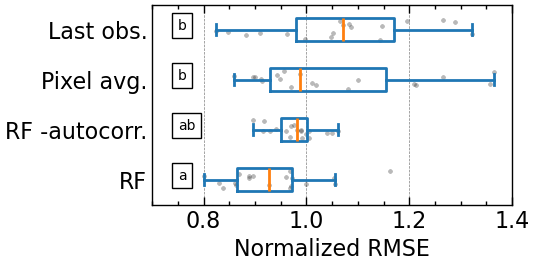

In [19]:
def fig4_ads_boxplot():
    model_to_y = {
        "full RF": '0',
        "noac RF": '1',
        "spatavg": '2',
        "lastobs": '3'
    }
    
    scatter_x = westmort_ads["nrmse"]
    scatter_y = westmort_ads["model"].replace(model_to_y).astype(int) + (0.2 * np.random.uniform(low=-1, high=1, size=westmort_ads.shape[0]))
    
    fig, ax = boxplot_annotate_comparison_result(westmort_ads, [0, 3, 1, 2], ["a", "b", "ab", "b"], annotation_x=0.75)
    ax.scatter(scatter_x, scatter_y, marker='x', s=5, c='0.1', alpha=0.3)
    ax.set_xlim(0.7, 1.4)
    ax.set_yticks([0, 1, 2, 3], labels=["RF", "RF -autocorr.", "Pixel avg.", "Last obs."])
    
    return fig, ax

fig, ax = fig4_ads_boxplot()
plt.show()

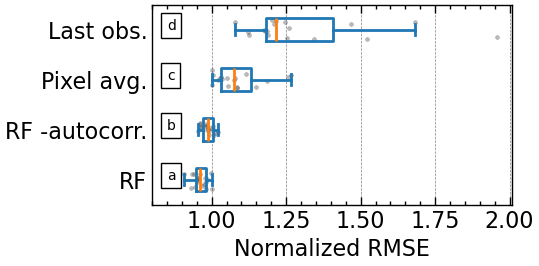

In [20]:
def figs1_gfw_boxplot():
    model_to_y = {
        "full RF": '0',
        "noac RF": '1',
        "spatavg": '2',
        "lastobs": '3'
    }
    
    scatter_x = westmort_gfw["nrmse"]
    scatter_y = westmort_gfw["model"].replace(model_to_y).astype(int) + (0.2 * np.random.uniform(low=-1, high=1, size=westmort_gfw.shape[0]))
    
    fig, ax = boxplot_annotate_comparison_result(westmort_gfw, [0, 3, 1, 2], ["a", "d", "b", "c"], annotation_x=0.85)
    ax.scatter(scatter_x, scatter_y, marker='x', s=5, c='0.1', alpha=0.3)
    ax.set_xlim(0.8, None)
    ax.set_yticks([0, 1, 2, 3], labels=["RF", "RF -autocorr.", "Pixel avg.", "Last obs."])

    return fig, ax

fig, ax = figs1_gfw_boxplot()
plt.show()

### SOAP/TEAK model performance comparison

In [21]:
soap = pd.read_csv("../data_out/soap_teak_rf_result.csv")
soap

,Unnamed: 0,mse,nrmse,r2,exp_var,model,data
0,0,0.002731,1.022311,-0.045120,0.001885,spatial average,ADS
1,1,0.061744,4.860644,-22.625864,-13.809653,last observation,ADS
2,2,0.056788,0.759215,0.423592,0.504899,last observation,ITM
3,3,0.039164,3.871155,-13.985839,-4.816113,RF noac,ADS
4,4,0.084033,0.923553,0.147049,0.214420,RF noac,ITM
5,5,0.041969,4.007372,-15.059033,-5.242418,RF full,ADS
6,6,0.051572,0.723512,0.476531,0.476818,RF full,ITM


Eh just use a table for this.

### West mort extent with inset regions

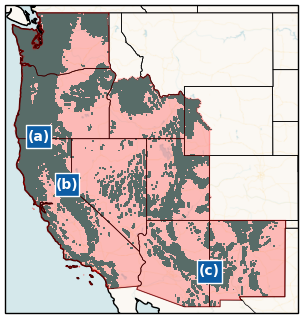

In [23]:
def get_fig5_inset_regions():
    regions = gpd.read_file("../data_in/figure_overlays.shp")
    regions["centroid_y"] = regions.geometry.centroid.y
    regions = regions.sort_values("centroid_y", ascending=False, ignore_index=True)
    regions["label"] = ["(a)", "(b)", "(c)"]

    return regions

regions = get_fig5_inset_regions()

def fig5_inset_extents():
    projection = ccrs.Mercator.GOOGLE
    tight_map_bbox = (-13947780.4623, -11360576.6138, 3620103.7979, 6343300.2344)
    #extent_ca = -126.024414, -113.021484, 31.575612, 42.998222
    
    tight_map_aspect = (tight_map_bbox[1] - tight_map_bbox[0]) / (tight_map_bbox[3] - tight_map_bbox[2])
    # ca_map_aspect = (extent_ca[1] - extent_ca[0]) / (extent_ca[3] - extent_ca[2])
    fig_height = 4
    fig_width = tight_map_aspect * fig_height
    
    # Start with the extent map, then remove legend and tighten the extent
    fig, ax = fig1_west_mort_extent()
    fig.set_size_inches(fig_width, fig_height)
    ax.get_legend().remove()
    ax.set_extent(tight_map_bbox, crs=projection)
    
    # Add summarization regions
    regions.plot(ax=ax, zorder=5, edgecolor="white")
    for x, y, label in zip(regions.centroid.x, regions.centroid.y, regions.label):
        ax.annotate(label, xy=(x, y), ha="center", va="center", color="white", weight="bold", zorder=5)

    return fig, ax

fig, ax = fig5_inset_extents()
plt.show()

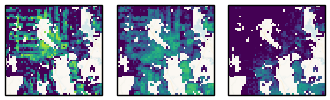

In [27]:
from matplotlib import colors
from matplotlib.cm import ScalarMappable
import pandas as pd

projection = ccrs.Mercator.GOOGLE

def get_2023_predict_result():
    ds23 = pd.read_csv("../data_out/west_ads_2023.csv")[["y", "x", "mort1", "rf_predict", "rf_predict_noac"]]\
        .set_index(["y", "x"]).to_xarray().to_array().rio.write_crs(3857)
    eps = 1e-3
    ds23 = (ds23 / 100) + eps
    return ds23

def make_clipped_plot(ds, geom, **kwargs):
    p = ds.rio.clip_box(*geom.bounds).plot(
        col="variable", 
        norm=colors.LogNorm(vmin=1e-2, vmax=1), 
        cbar_kwargs=dict(label="Proportion of cell with mortality"),
        xticks=[],
        yticks=[],
        add_labels=False,
        subplot_kws=dict(projection=projection),
        **kwargs
    )
    
    for ax in p.axs.flat:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")
        cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=projection, attribution=False)

    p.fig.tight_layout()
    return p

ds23 = get_2023_predict_result()

def fig5_row_a():
    return make_clipped_plot(ds23, regions.geometry[0], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")

def fig5_row_b():
    return make_clipped_plot(ds23, regions.geometry[1], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")

def fig5_row_c():
    return make_clipped_plot(ds23, regions.geometry[2], add_colorbar=False, size=4 * 0.9 / 3, cmap="viridis")


fig5_row_a()
plt.show()

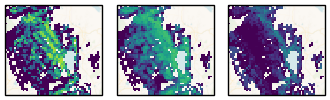

In [28]:
fig5_row_b()
plt.show()

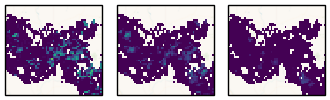

In [29]:
fig5_row_c()
plt.show()

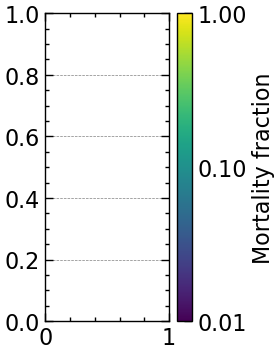

In [30]:
# Just the color bar
def fig5_colorbar():
    fig, ax = plt.subplots(figsize=(2, 4))
    
    cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=colors.LogNorm(vmin=1e-2, vmax=1), cmap='viridis'),
                 ax=ax, orientation='vertical', label='Mortality fraction', format=matplotlib.ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
    
    return fig, ax

fig, ax = fig5_colorbar()
plt.show()

### Export all figures

Search the main module for all functions that start with "fig", repeatedly call them and then save the resulting figures to the output directory.

<module '__main__'>


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


AC(1) vs. mean IoU correlation: 0.5053798698384293


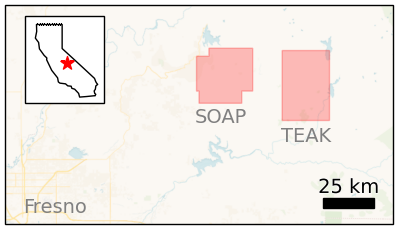

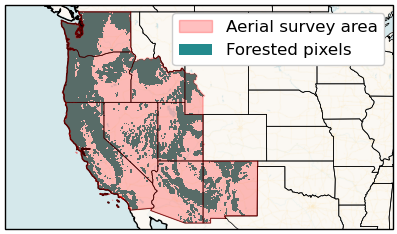

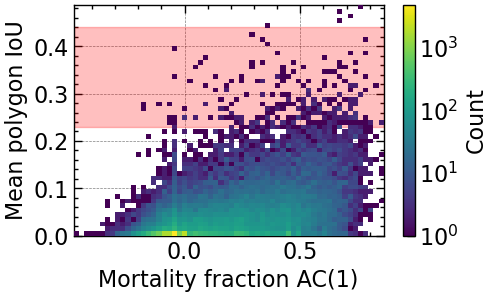

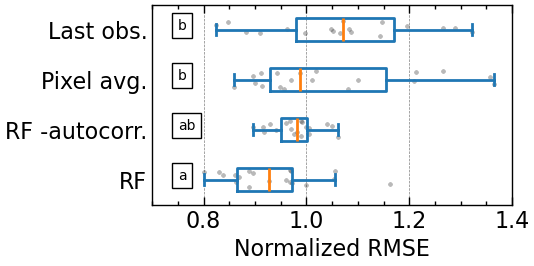

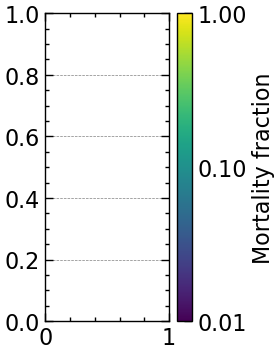

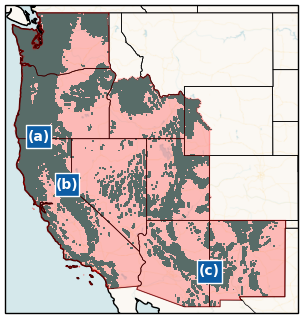

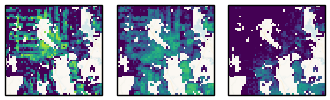

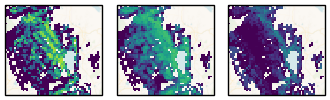

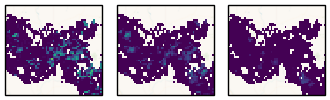

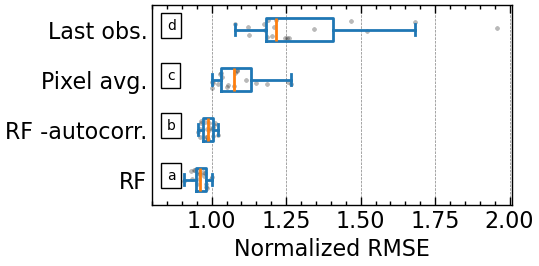

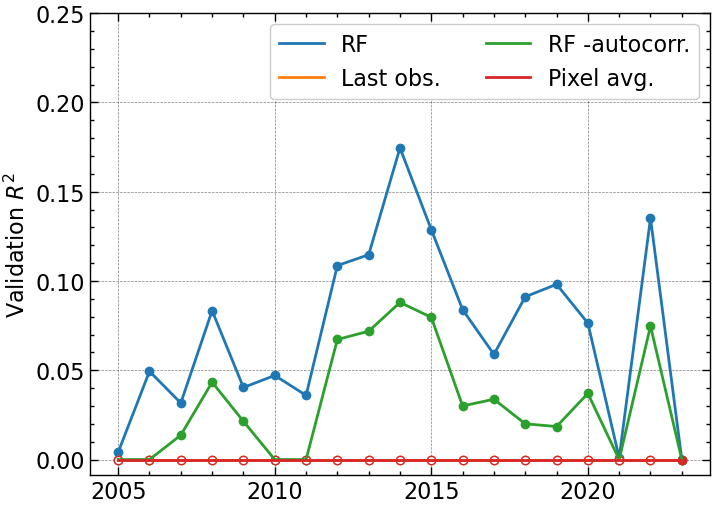

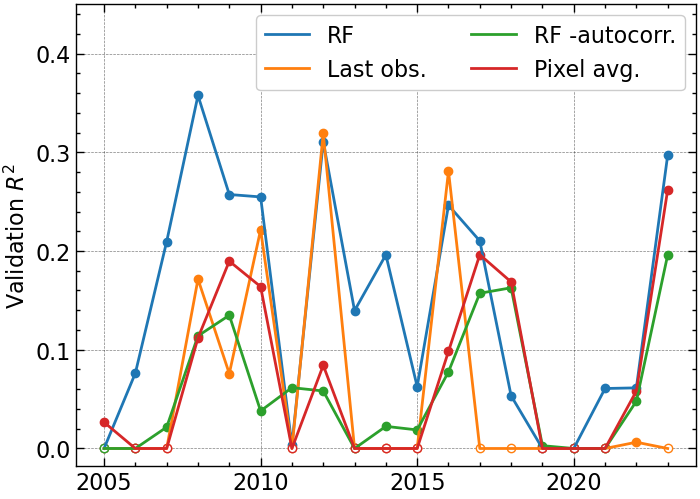

In [34]:
import sys
import os
main_module = sys.modules[__name__]
print(main_module)

fig_functions = [f for f in dir() if f.startswith("fig") and callable(getattr(main_module, f))]

for f in fig_functions:
    func = getattr(main_module, f)
    p = func()
    plt.savefig(os.path.join(OUTPUT_FIGURE_DIRECTORY, f+".png"))